In [37]:
import numpy as np
from matplotlib import pyplot as plt
import types
import itertools
import copy
from scipy.linalg import svd as svd
from sklearn.datasets import make_swiss_roll
%matplotlib notebook

## GTM Object

In [38]:
class GTM(object):
    
    def __init__(self, n_components, latent_size, basis = 'gaussian', n_basis = None, latent_range = [-1, 1], n_init = 1, max_iter = 300, sigma = 1, tol = 0.001, reg_covar = 1e-3, standardise_flag = True, verbose = False, vectorise = False):
        pass
    
        #Initialise attributes
        self.n_components = n_components
        self.latent_size = latent_size
        self.n_points = int(self.n_components ** self.latent_size)
        self.basis = basis
        
        if n_basis is None:
            self.n_basis = int(self.n_components**self.latent_size)
            #Only for if you use gaussian basis functions and need to figure out how many you need
            
        
        else:
            self.n_basis = n_basis #use prescribed number of basis vectors in k-means clustering
                
        self.latent_range = latent_range
        self.n_init = n_init
        self.max_iter = max_iter
        self.sigma = sigma
        self.tol = tol
        self.reg_covar = reg_covar
        self.standardise_flag = standardise_flag
        self.verbose = verbose
        self.vectorise = vectorise
        
        #Define mixture coefficients
        self.mix_ = np.ones(self.n_points) / self.n_points
        
        #make grid and latent points
        self.make_grid()
        
        #initialise basis functions
        self.basis_initialisation()
        
        #Check basis
        self.check_basis()
        
        #useful attributes
        self.weight_ = None
        self.variance_ = None
        
        
    def make_grid(self):
        
        if self.latent_size == 1:
            self.means_ = np.linspace(self.latent_range[0], self.latent_range[1], self.n_components)
            self.grid_points = np.arange(0, self.n_components, 1)
        
        elif self.latent_size == 2:
            X, Y = np.meshgrid(np.linspace(self.latent_range[0], self.latent_range[1], self.n_components), 
                           np.linspace(self.latent_range[0], self.latent_range[1], self.n_components))
        
            P1, P2 = np.meshgrid(np.arange(0, self.n_components, 1), 
                               np.arange(0, self.n_components, 1))

            self.means_ = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
            self.grid_points = np.hstack((P1.reshape(-1, 1), P2.reshape(-1, 1)))
        
        else:
            print("Latent size is too large.")
            raise SystemExit
    
    def initialise_gaussian_centers(self):
        
        if self.n_basis == self.n_points:
            self.gauss_centers = self.means_
        
        elif self.n_basis < self.n_points:
            print("K-means version not implemented.")
            raise SystemExit
        
        else:
            print("You cannot have more kernel centers ({}) than available latent points ({}).".format(self.n_basis, self.n_points))
            raise SystemExit
    
        
    def polynomal_basis(self, x):
        
        if not hasattr(self, "poly_powers"):
            f = x.shape[0]
            self.poly_powers = np.array(list(itertools.combinations_with_replacement(range(0, self.orders + 1), f)))
        
        return np.product(x.T**self.poly_powers, axis = 1, keepdims = True)
    
    def gaussian_basis(self, x): #np.exp(-1 * sigma / 2 * ||x - c||_2^2)
        
        if self.vectorise:
            
            errors = np.sum((self.gauss_centers - x.T)**2, axis = 1, keepdims = True)
        
        else:
            errors = np.zeros((self.n_basis, 1))
            
            for i in range(self.n_basis):
                errors[i, 0] = np.sum((self.gauss_centers[[i], :] - x.T)**2, axis = 1)
        
        return np.exp(-1 * self.sigma/2 * errors)
    
    def basis_initialisation(self):
        
        if isinstance(self.basis, types.FunctionType):
            self.basis_function = self.basis
            
            #check basis
            self.check_basis()
            
        elif isinstance(self.basis, str):
            
            if self.basis.lower() == "linear":
                
                self.basis_function = self.polynomal_basis
                self.orders = 1
            
            elif self.basis.lower() == "quadratic":
                
                self.basis_function = self.polynomal_basis
                self.orders = 2
                
            elif self.basis.lower() == "cubic":
                
                self.basis_function = self.polynomal_basis
                self.orders = 3
                
            elif self.basis.lower() == "quartic":
                
                self.basis_function = self.polynomal_basis
                self.orders = 4
            
            elif self.basis.lower() == 'gaussian':
                self.initialise_gaussian_centers()
                self.basis_function = self.gaussian_basis
                self.orders = None
        
        else:
            print("Unknown basis entered.")
            raise SystemExit
    
    def check_basis(self):
        #check function
            x = np.zeros((self.latent_size, 1))
            
            r, c = self.basis_function(x).shape
            
            assert(c == 1), print("Basis function does not return vectors: {} x {} output".format(r, c))
    
    def evaluate_gauss(self, x, mu, covariance):
        #All vector/matrix inputs (so that shape is fine)
        #You could also store the precisions, may make this evaluation faster
        
        precision = np.linalg.inv(covariance) #This is fine as we have a spherical covariance (diag[Beta])
        
        if self.vectorise:
            D = x.shape[1]
            z = x - mu.reshape(1, -1) #reshape mu
            
            second_part = np.exp((-1 / 2) * np.sum(np.dot(z, precision) * z, axis = 1))
        
        else: #vector inputs for mu and x_vec
            D = x.shape[0]
            z = x - mu
        
            second_part = np.exp((-1 / 2) * np.dot(z.T, np.linalg.solve(covariance, z)))
            
        first_part = 1 / ((2 * np.pi)**(D / 2))  * 1 / (np.linalg.det(covariance)**(1/2))
        
        return first_part * second_part
    
    def evaluate_log_gauss(self, x, mu, covariance):
        #All vector/matrix inputs (so that shape is fine)
        #You could also store the precisions, may make this evaluation faster
        
        precision = np.linalg.inv(covariance) #This is fine as we have a spherical covariance (diag[Beta])
        
        if self.vectorise:
            D = x.shape[1]
            z = x - mu.reshape(1, -1)
            
            third_part = -1/2 * np.sum(np.dot(z, precision) * z, axis = 1)
        
        else:     
            D = x.shape[0]
            z = x - mu
            third_part = -1/2 * np.dot(z.T, np.linalg.solve(covariance, z))

        first_part = -D/2 * np.log(2 * np.pi)
        second_part = -1/2 * np.log(np.linalg.det(covariance))
        
        return first_part + second_part + third_part
    
    def data_likelihood(self, x): #p(x)
        
        #use log-sum-exp to ensure that you do not hit numerical underflow!
        mix = self.mix_
        mu = self.forward_propagate_means() #Actually Mi = y(W, u_i)
        cov = np.eye(self.n_features) / self.variance_
        
        if x.shape[1] == 1:
            N = 1
        else:
            N = x.shape[0]
        
        log_likelihoods = np.zeros((N, self.n_points))
        
        for k in range(self.n_points):
            
            mean_vec = mu[[k], :].T #N x 1 vector
            
            if N == 1:
                log_likelihoods[0, k] = self.evaluate_log_gauss(x, mean_vec, cov) + np.log(mix[k])
                
            elif N != 1 and self.vectorise:
                log_likelihoods[:, k] = self.evaluate_log_gauss(x, mean_vec, cov) + np.log(mix[k])
            
            if N != 1 and not self.vectorise:
                
                for i in range(N):
                    log_likelihoods[i, k] = self.evaluate_log_gauss(x[[i], :].T, mean_vec, cov) + np.log(mix[k])

        #Apply log-sum-exp trick
        A = np.max(log_likelihoods, axis = 1, keepdims=True)
    
        log_likelihood_sum = A + np.log(np.sum(np.exp(log_likelihoods - A), axis = 1, keepdims = True))
        
        p_x = np.exp(log_likelihood_sum)
        
        return p_x, log_likelihoods, log_likelihood_sum
    
    def posterior_likelihood(self, x): #Calculates the responsibilities 
        
        _, log_likelihoods, log_likelihood_sum = self.data_likelihood(x)
        
        responsibility = np.exp(log_likelihoods - log_likelihood_sum)
        
        return responsibility
    
    def log_likelihood(self, X, sum_flag = True): #return the log-likelihood sum
        
        N = X.shape[0]

        LL = np.zeros((N, 1))
        
        if self.vectorise:
            LL = self.data_likelihood(X)[2]
        
        else:
            for i in range(N):

                x_vec = X[[i], :].T #N x 1 vector

                #Add log-likelihood
                LL[i, 0] = self.data_likelihood(x_vec)[2]
        
        if sum_flag:
            return np.mean(LL)
        
        else:
            return LL
    
    def PCA_fit(self, X):
        
        if not hasattr(self, "mean_"):
            self.mean_ = np.mean(X, axis = 0)
        
        #Decompose X
        U, s, Vh = svd(X - self.mean_, full_matrices = False)
        
        #Perform sign correction to ensure consistent SVD output
        U, Vh = self.svd_flip(U, Vh)
        
        if self.latent_size < self.n_features:
            #Explained variance (eigenvalues)
            self.PCA_eigenvalues_ = s**2 / (self.n_samples - 1)

        
        else:
            #Explained variance (eigenvalues)
            self.PCA_eigenvalues_ = s**2 / (self.n_samples - 1)
        
        #Save important components
        self.U = U
        self.s = s
        self.PCA_components_ = Vh[:self.latent_size]
        self.variance_ = self.PCA_eigenvalues_[self.latent_size]
    
    def svd_flip(self, u, v, u_based_decision=True):
        """Sign correction to ensure deterministic output from SVD.
        Adjusts the columns of u and the rows of v such that the loadings in the
        columns in u that are largest in absolute value are always positive.
        Parameters
        ----------
        u : ndarray
            u and v are the output of `linalg.svd` or
            :func:`~sklearn.utils.extmath.randomized_svd`, with matching inner
            dimensions so one can compute `np.dot(u * s, v)`.
        v : ndarray
            u and v are the output of `linalg.svd` or
            :func:`~sklearn.utils.extmath.randomized_svd`, with matching inner
            dimensions so one can compute `np.dot(u * s, v)`.
            The input v should really be called vt to be consistent with scipy's
            output.
        u_based_decision : bool, default=True
            If True, use the columns of u as the basis for sign flipping.
            Otherwise, use the rows of v. The choice of which variable to base the
            decision on is generally algorithm dependent.
        Returns
        -------
        u_adjusted, v_adjusted : arrays with the same dimensions as the input.
        """
        if u_based_decision:
            # columns of u, rows of v
            max_abs_cols = np.argmax(np.abs(u), axis=0)
            signs = np.sign(u[max_abs_cols, range(u.shape[1])])
            u *= signs
            v *= signs[:, np.newaxis]
        else:
            # rows of v, columns of u
            max_abs_rows = np.argmax(np.abs(v), axis=1)
            signs = np.sign(v[range(v.shape[0]), max_abs_rows])
            u *= signs
            v *= signs[:, np.newaxis]
        return u, v
    
    def standardise(self, X, reverse_flag = False):
        
        if reverse_flag:
            
            if hasattr(self, "mean_") and hasattr(self, "std_"):
            
                return X * self.std_ + self.mean_
            
            else:
                print("Error in standardisation. No mean_ and std_ attributes")
                raise SystemExit
        
        else:
            self.mean_ = np.mean(X, axis = 0, keepdims = True)
            self.std_ = np.std(X, axis = 0, keepdims = True)

            return (X - self.mean_) / self.std_
    
    def initialise_weights(self, X):
        
        #Solve for Vh
        self.PCA_fit(X)
        
        #Determine targets
        T = np.dot(self.means_, self.PCA_components_)
        
        fig = plt.figure(figsize = (12, 10))
        fig.suptitle("PCA transform of the latent grid")
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(T[:, 0], T[:, 1], T[:, 2])
        plt.show()
        
        ATA = np.dot(self.B_matrix.T, self.B_matrix)
        ATB = np.dot(self.B_matrix.T, T)
        
        weights = np.linalg.solve(ATA, ATB)
        
        return weights.T
    
    
    def basis_matrix(self):
        n_samples = self.means_.shape[0]
        
        b_mat = []
        
        for i in range(n_samples):
            b_out = self.basis_function(self.means_[[i], :].T)
            b_mat.append(b_out[:, 0])
            
        return np.array(b_mat) #N x M matrix
    
    def forward_propagate_means(self):
        
        return np.dot(self.B_matrix, self.weights_.T)
    
    def update_R(self, X):
        #Update R and G based on old weights
        self._R = self.posterior_likelihood(X)
        self._G = np.diag(np.sum(self._R, axis = 0))
    
    def update_W(self, X):
        
        #Solve for new weights
        ATGA = np.dot(np.dot(self.B_matrix.T, self._G), self.B_matrix)
        ATRB = np.dot(np.dot(self.B_matrix.T, self._R.T), X)
        
        Wnew = np.linalg.solve(ATGA, ATRB)
        
        return Wnew.T
    
    def update_variance(self, X):
        
        N, D = X.shape
        
        M = self.forward_propagate_means()
        
        variance_new = 0
        
        for i in range(self.n_points):
            variance_new += np.sum(self._R[:, i] * np.sum((X - M[[i], :])**2, axis = 1))
        
        return variance_new / (N * D)
    
    
    def fit(self, X):
        
        self.n_samples, self.n_features = X.shape
        
        if self.standardise_flag:
            X = copy.deepcopy(X)
            X = self.standardise(X, reverse_flag = False)
        
        #Determine B matrix (constant)
        self.B_matrix = self.basis_matrix()
        
        #Initialise weight matrix
        self.weights_ = self.initialise_weights(X)
        
        training_LL = [self.log_likelihood(X)]
        tol = np.inf
        
        while tol > self.tol:
            #Update R
            self.update_R(X)

            #Update W
            self.weights_ = self.update_W(X)

            #Update variance
            self.variance_ = 1 / self.update_variance(X) + self.reg_covar

            #Calculate likelihood
            new_LL = self.log_likelihood(X)
            tol = np.abs(new_LL - training_LL[-1])
            training_LL.append(new_LL)
            
        plt.figure()
        plt.plot(training_LL)
        plt.show()
        
        return self 

## Swiss roll dataset

<IPython.core.display.Javascript object>


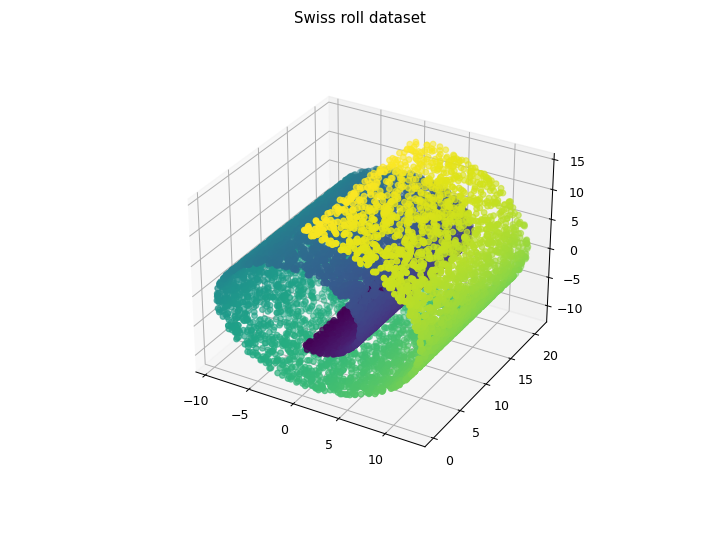

In [39]:
X, l = make_swiss_roll(n_samples=10000, noise=0.0, random_state=None)
fig = plt.figure(figsize = (8, 6))
fig.suptitle("Swiss roll dataset")
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = l)
plt.show()

## Test GTM instance

<IPython.core.display.Javascript object>


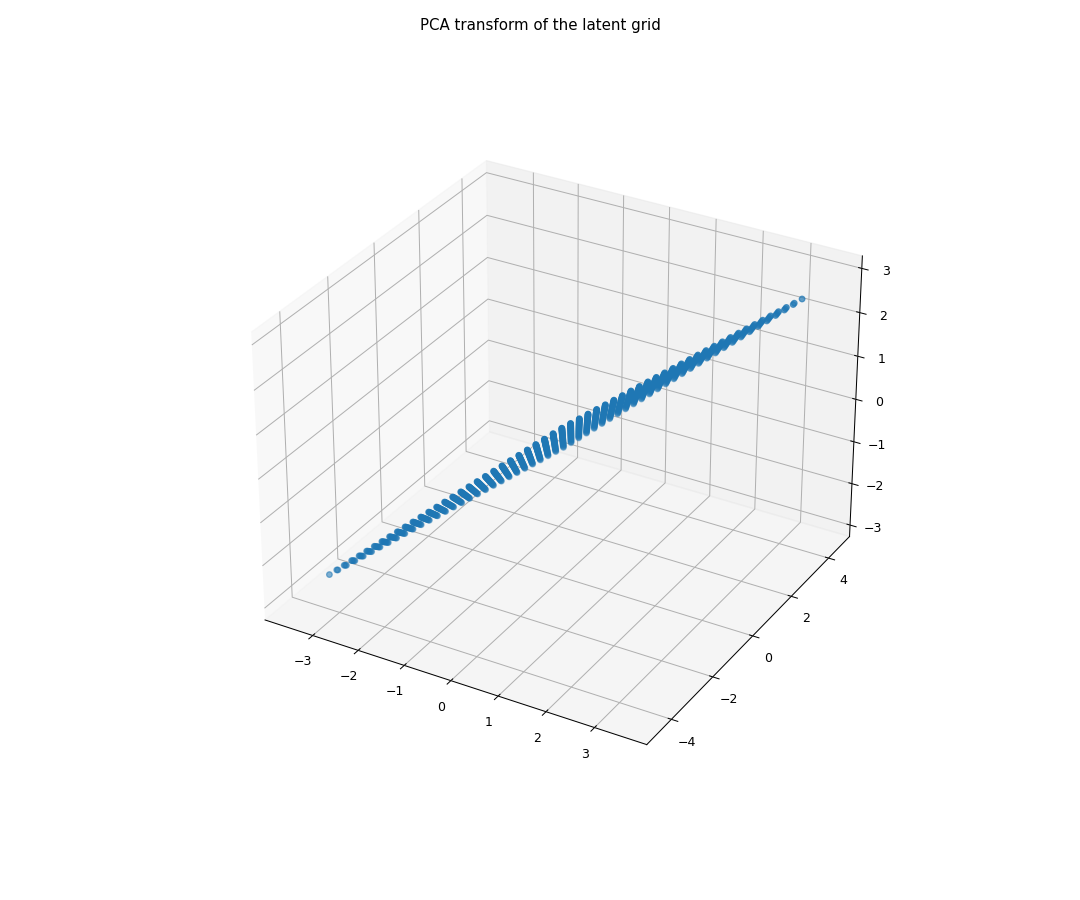

<IPython.core.display.Javascript object>


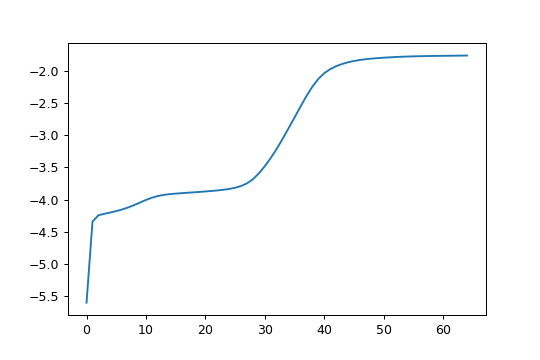

(900, 3)


<IPython.core.display.Javascript object>


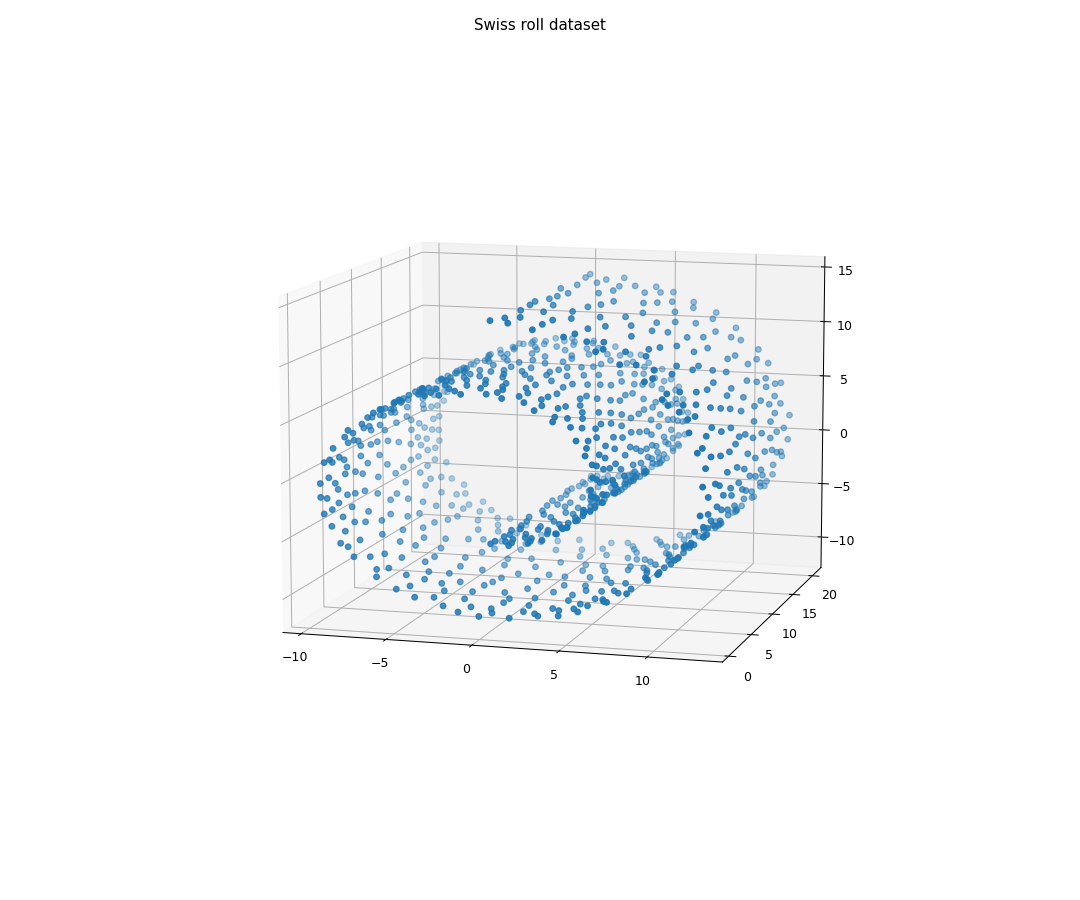

In [40]:
gtm = GTM(n_components = 30,
        latent_size = 2,
        basis = 'gaussian',
        n_basis = None,
        latent_range = [-4, 4],
        n_init = 1,
        max_iter = 300,
        sigma = 10,
        tol = 0.001,
        reg_covar = 0.001,
        standardise_flag = True,
        verbose = False,
        vectorise = True).fit(X)

L = gtm.forward_propagate_means() * gtm.std_ + gtm.mean_
print(L.shape)

fig = plt.figure(figsize = (12, 10))
fig.suptitle("Swiss roll dataset")
ax = fig.add_subplot(111, projection='3d')
ax.scatter(L[:, 0], L[:, 1], L[:, 2])
plt.show()       